In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc


import data_utils
import modeling

%load_ext autoreload
%autoreload 2

SEED = 42
model_to_auc = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hparam Tuning

In [697]:
# Load data
X, y = data_utils.load_dataset(include_demo=True, include_wsi=False, include_omics=False, omics_n_components=5, wsi_n_components=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y['event'])

In [700]:
hparams = dict(
    learning_rate=1,
    n_estimators=200,
    subsample=0.8,
    min_samples_leaf=4,
    max_features=0.5,
    # validation_fraction=0.2,
    # n_iter_no_change=5,
    dropout_rate=0.1,
    random_state=SEED
)
model = GradientBoostingSurvivalAnalysis(**hparams).fit(X_train, y_train)

In [701]:
c, b, a = modeling.get_test_scores(model, X_train, y_train, y)
print('TRAIN SCORES')
print(f"Concordance index: {c:.3f}")
print(f"IBS: {b:.3f}")
print(f"Mean AUC: {a[-1]:.3f}")
print()
c, b, a = modeling.get_test_scores(model, X_test, y_test, y)
print('TEST SCORES')
print(f"Concordance index: {c:.3f}")
print(f"IBS: {b:.3f}")
print(f"Mean AUC: {a[-1]:.3f}")

TRAIN SCORES
Concordance index: 0.759
IBS: 0.137
Mean AUC: 0.807

TEST SCORES
Concordance index: 0.733
IBS: 0.141
Mean AUC: 0.764


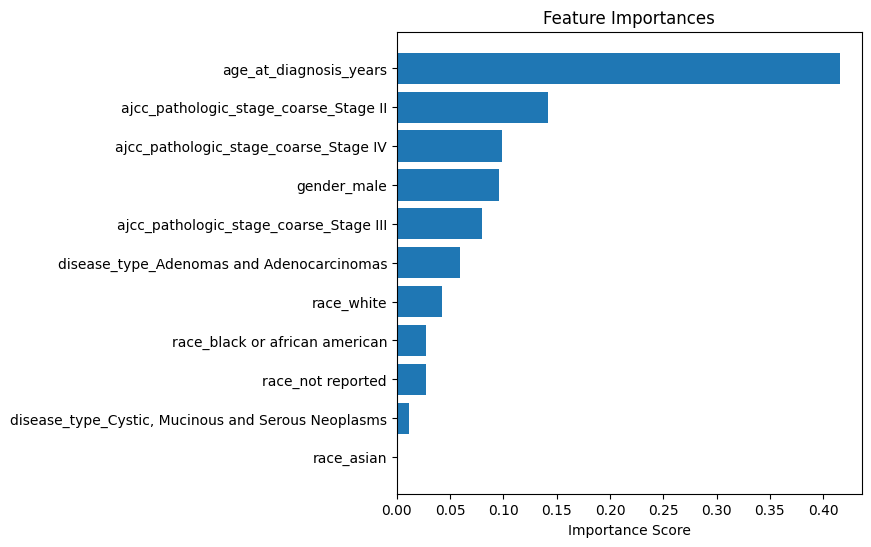

In [702]:
# Feature importances
model.feature_importances_
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.show()

## Eval

In [707]:
model = GradientBoostingSurvivalAnalysis(**hparams)

### 5 fold CV

In [704]:
def scoring_fn(model, X_, y_):
    c, b, a = modeling.get_test_scores(model, X_, y_, y)
    return {'c-index': c, 'ibs': b, 'auc': a[-1]}

In [705]:
out = cross_validate(model, X, y, scoring=scoring_fn, cv=5)

In [706]:
c, b, a = out['test_c-index'], out['test_ibs'], out['test_auc']
print(f'CV C-index: {c.mean():.3f} ± {c.std():.3f}')
print(f'CV IBS: {b.mean():.3f} ± {b.std():.3f}')
print(f'CV mAUC: {a.mean():.3f} ± {a.std():.3f}')

CV C-index: 0.680 ± 0.038
CV IBS: 0.155 ± 0.010
CV mAUC: 0.717 ± 0.044


### Dynamic ROC AUC

In [676]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED + 1, stratify=y['event'])

In [677]:
model.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(dropout_rate=0.2, learning_rate=1, max_depth=2,
                                 max_features=0.5, min_samples_leaf=8,
                                 n_estimators=200, random_state=42,
                                 subsample=0.9)

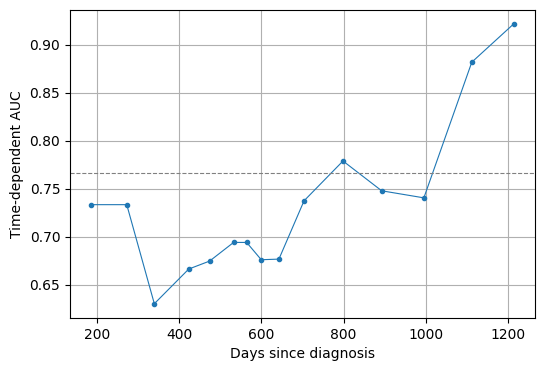

In [678]:
times = np.percentile(y['survival_time'], np.linspace(10, 81, 15))
risk_scores = model.predict(X_test)
aucs = cumulative_dynamic_auc(y, y_test, risk_scores, times)
plt.figure(figsize=(6, 4))
plt.plot(times, aucs[0], marker="o", markersize=3, linewidth=0.8, color='C0')
plt.axhline(aucs[-1], linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Days since diagnosis")
plt.ylabel("Time-dependent AUC")
plt.grid(True)

In [679]:
model_to_auc['Demo+WSI'] = aucs[0]

### Failure Cases

In [742]:
cases = pd.read_csv('data/case_data_filtered.csv')
file_sizes = pd.read_csv('data/wsi_sizes.csv')
cases = cases.merge(file_sizes, on='case_id', how='left')
cases.set_index('case_id', inplace=True)

In [743]:
def find_discordances(risk_scores, y):
    """ For each sample, count how often its risk score violates the expected ordering with other
    samples.
    """
    n_samples = len(risk_scores)
    discordances = np.zeros(n_samples)
    comparisons = np.zeros(n_samples)

    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                continue
            # Only compare if we can determine correct ordering
            # (one died before other's last follow-up)
            if y[i]['event'] and (y[i]['survival_time'] < y[j]['survival_time']):
                # i died before j's last follow-up i should have higher risk score
                comparisons[i] += 1
                comparisons[j] += 1
                if risk_scores[i] < risk_scores[j]:
                    discordances[i] += 1
                    discordances[j] += 1

    comparisons[comparisons == 0] = np.nan
    return discordances / comparisons, comparisons

In [750]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED + 1, stratify=y['event'])

In [751]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [752]:
discordances, comparisons = find_discordances(preds, y_test)
discordances = (discordances - discordances.mean()) / discordances.std()

In [753]:
df = cases.loc[X_test.index].copy().assign(discordance=discordances, comparisons=comparisons)
df = df[df.comparisons >= 8]

In [754]:
df.groupby(pd.qcut(df.age_at_diagnosis_years, 5))['discordance'].agg(['mean', 'count'])

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_83126/3215449720.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.age_at_diagnosis_years, 5))['discordance'].agg(['mean', 'count'])


,mean,count
age_at_diagnosis_years,,
"(38.999, 59.0]",0.095527,28
"(59.0, 65.0]",-0.001780,26
"(65.0, 71.0]",-0.051327,29
"(71.0, 75.0]",0.130264,22
"(75.0, 87.0]",0.024038,26


In [755]:
df.groupby('race').discordance.agg(['mean', 'count'])

,mean,count
race,,
asian,-0.816655,2
black or african american,0.287166,21
not reported,-0.305421,12
white,-0.022482,102


In [756]:
df.groupby(pd.qcut(df.survival_time, 5))['discordance'].mean()

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_83126/1791331223.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.survival_time, 5))['discordance'].mean()


survival_time
(3.999, 427.8]     -0.080636
(427.8, 610.0]      0.120432
(610.0, 826.6]     -0.087159
(826.6, 1284.0]     0.168001
(1284.0, 4765.0]   -0.176614
Name: discordance, dtype: float64

In [757]:
df.groupby('gender').discordance.agg(['mean', 'count'])

,mean,count
gender,,
female,0.010699,74
male,-0.037345,63


In [758]:
df.groupby('ajcc_pathologic_stage_coarse').discordance.agg(['count', 'mean'])

,count,mean
ajcc_pathologic_stage_coarse,,
Stage I,78,-0.260671
Stage II,29,0.144088
Stage III,20,0.663146
Stage IV,7,0.302701


In [759]:
df.groupby('disease_type').discordance.agg(['count', 'mean'])

,count,mean
disease_type,,
Acinar Cell Neoplasms,5,-0.523275
Adenomas and Adenocarcinomas,125,0.027842
"Cystic, Mucinous and Serous Neoplasms",7,-0.346405


In [760]:
df.groupby(pd.qcut(df.file_size, 5)).discordance.agg(['count', 'mean'])

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_83126/3803734945.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df.file_size, 5)).discordance.agg(['count', 'mean'])


,count,mean
file_size,,
"(0.0366, 0.228]",28,-0.182761
"(0.228, 0.495]",27,-0.033666
"(0.495, 0.798]",27,-0.043936
"(0.798, 1.342]",27,0.137432
"(1.342, 4.086]",28,0.069318


### Cross-model ROC curves

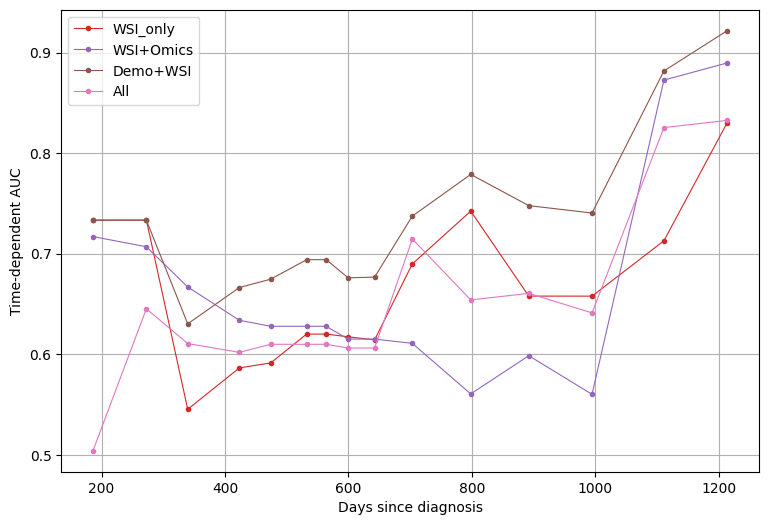

In [681]:
model_to_auc_ = {k: model_to_auc[k] for k in ['WSI_only', 'WSI+Omics', 'Demo+WSI', 'All']}
times = np.percentile(y['survival_time'], np.linspace(10, 81, 15))
plt.figure(figsize=(9, 6))
for i, (name, aucs) in enumerate(model_to_auc_.items(), start=3):
    plt.plot(times, aucs, marker="o", markersize=3, linewidth=0.8, color=f'C{i}', label=name)
    # plt.axhline(np.mean(aucs), linestyle="--", linewidth=0.8, color=f'C{i}')
plt.xlabel("Days since diagnosis")
plt.ylabel("Time-dependent AUC")
plt.legend()
plt.grid(True)

In [667]:
list(model_to_auc.keys())

['Demo_only', 'Omics_only', 'Demo+Omics', 'WSI+Omics', 'All', 'WSI_only']